##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Optimizers with Core APIs

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/core/optimizers_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/core/optimizers_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

This notebook introduces the process of creating custom optimizers with the [TensorFlow Core low-level APIs](https://www.tensorflow.org/guide/core). Visit the [Core APIs overview](https://www.tensorflow.org/guide/core) to learn more about TensorFlow Core and its intended use cases. 

The [Keras optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) module is the recommended optimization toolkit for many general training purposes. It includes a variety of prebuilt optimiziers as well as subclassing functionality for customization. The Keras optimizers are also compatible with custom layers, models, and training loops built with the Core APIs. These prebuilt and customizable optimizers are suitable for most cases, but the Core APIs allow for complete control over the optimization process. For example, techniques such as Sharpness-Aware Minimization (SAM) require the model and optimizer to be coupled, which does not fit the traditional definition of ML optimizers. This guide walks through the process of building custom optimizers from scratch with the Core APIs, giving you the power to have full control over the structure, implementation, and behavior of your optimizers.

## Optimizers overview

An optimizer is an algorithm used to minimize a loss function with respect to a model's trainable parameters. The most straightforward optimization technique is gradient descent, which iteratively updates a model's parameters by taking a step in the direction of its loss function's steepest descent. Its step size is directly proportional to the size of the gradient, which can be problematic when the gradient is either too large or too small. There are many other gradient-based optimizers such as Adam, Adagrad, and RMSprop that leverage various mathematical properties of gradients for memory efficiency and fast convergence.

## Setup

In [2]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [3]:
import tensorflow as tf
print(tf.__version__)
# set random seed for reproducible results 
tf.random.set_seed(22)

2024-07-19 03:06:14.932381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 03:06:14.953482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 03:06:14.959703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.17.0


## Gradient descent

The basic optimizer class should have an initialization method and a function to update a list of variables given a list of gradients. Start by implementing the basic gradient descent optimizer which updates each variable by subtracting its gradient scaled by a learning rate.

In [4]:
class GradientDescent(tf.Module):

  def __init__(self, learning_rate=1e-3):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables
    for grad, var in zip(grads, vars):
      var.assign_sub(self.learning_rate*grad)

To test this optimizer, create a sample loss function to minimize with respect to a single variable, $x$. Compute its gradient function and solve for its minimizing parameter value:

$$L = 2x^4 + 3x^3 + 2$$

$$\frac{dL}{dx} = 8x^3 + 9x^2$$

$\frac{dL}{dx}$ is 0 at $x = 0$, which is a saddle point and at $x = - \frac{9}{8}$, which is the global minimum. Therefore, the loss function is optimized at $x^\star = - \frac{9}{8}$.

I0000 00:00:1721358377.407075  183462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721358377.410806  183462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721358377.414606  183462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721358377.418394  183462 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

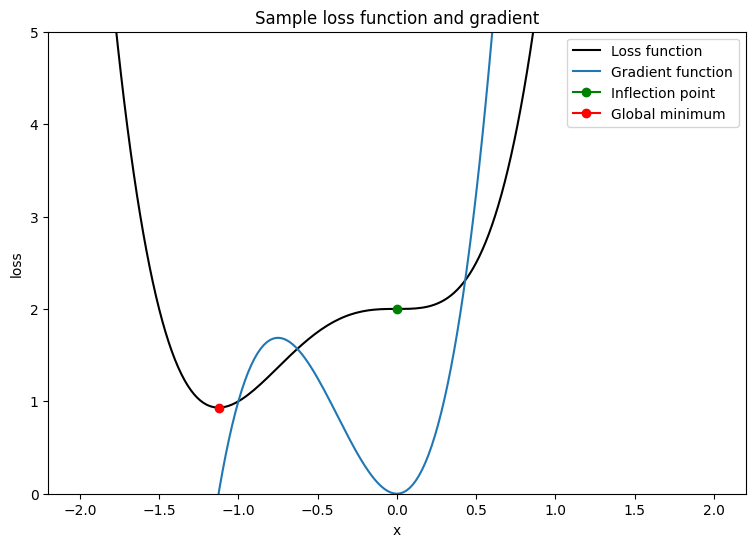

In [5]:
x_vals = tf.linspace(-2, 2, 201)
x_vals = tf.cast(x_vals, tf.float32)

def loss(x):
  return 2*(x**4) + 3*(x**3) + 2

def grad(f, x):
  with tf.GradientTape() as tape:
    tape.watch(x)
    result = f(x)
  return tape.gradient(result, x)

plt.plot(x_vals, loss(x_vals), c='k', label = "Loss function")
plt.plot(x_vals, grad(loss, x_vals), c='tab:blue', label = "Gradient function")
plt.plot(0, loss(0),  marker="o", c='g', label = "Inflection point")
plt.plot(-9/8, loss(-9/8),  marker="o", c='r', label = "Global minimum")
plt.legend()
plt.ylim(0,5)
plt.xlabel("x")
plt.ylabel("loss")
plt.title("Sample loss function and gradient");

Write a function to test the convergence of an optimizer with a single variable loss function. Assume that convergence has been achieved when the updated parameter's value at timestep $t$ is the same as its value held at timestep $t-1$. Terminate the test after a set number of iterations and also keep track of any exploding gradients during the process. In order to truly challenge the optimization algorithm, initialize the parameter poorly. In the above example, $x = 2$ is a good choice since it involves an steep gradient and also leads into an inflection point.

In [6]:
def convergence_test(optimizer, loss_fn, grad_fn=grad, init_val=2., max_iters=2000):
  # Function for optimizer convergence test
  print(optimizer.title)
  print("-------------------------------")
  # Initializing variables and structures
  x_star = tf.Variable(init_val)
  param_path = []
  converged = False

  for iter in range(1, max_iters + 1):
    x_grad = grad_fn(loss_fn, x_star)

    # Case for exploding gradient
    if tf.math.is_nan(x_grad):
      print(f"Gradient exploded at iteration {iter}\n")
      return []

    # Updating the variable and storing its old-version
    x_old = x_star.numpy()
    optimizer.apply_gradients([x_grad], [x_star])
    param_path.append(x_star.numpy())

    # Checking for convergence
    if x_star == x_old:
      print(f"Converged in {iter} iterations\n")
      converged = True
      break
      
  # Print early termination message
  if not converged:
    print(f"Exceeded maximum of {max_iters} iterations. Test terminated.\n")
  return param_path

Test the convergence of the gradient descent optimizer for the following learning rates: 1e-3, 1e-2, 1e-1

In [7]:
param_map_gd = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_gd[learning_rate] = (convergence_test(
      GradientDescent(learning_rate=learning_rate), loss_fn=loss))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



Visualize the path of the parameters over a contour plot of the loss function.

In [8]:
def viz_paths(param_map, x_vals, loss_fn, title, max_iters=2000):
  # Creating a controur plot of the loss function
  t_vals = tf.range(1., max_iters + 100.)
  t_grid, x_grid = tf.meshgrid(t_vals, x_vals)
  loss_grid = tf.math.log(loss_fn(x_grid))
  plt.pcolormesh(t_vals, x_vals, loss_grid, vmin=0, shading='nearest')
  colors = ['r', 'w', 'c']
  # Plotting the parameter paths over the contour plot
  for i, learning_rate in enumerate(param_map):
    param_path = param_map[learning_rate]
    if len(param_path) > 0:
      x_star = param_path[-1]
      plt.plot(t_vals[:len(param_path)], param_path, c=colors[i])
      plt.plot(len(param_path), x_star, marker='o', c=colors[i], 
              label = f"x*: learning rate={learning_rate}")
  plt.xlabel("Iterations")
  plt.ylabel("Parameter value")
  plt.legend()
  plt.title(f"{title} parameter paths")

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


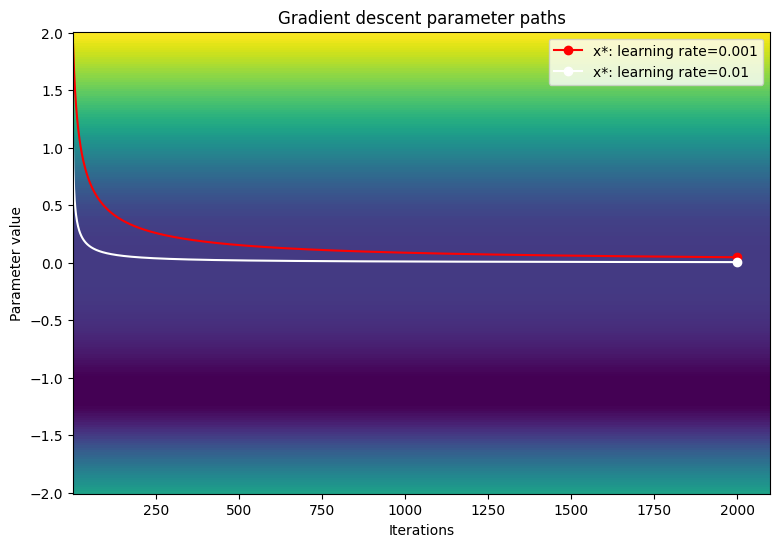

In [9]:
viz_paths(param_map_gd, x_vals, loss, "Gradient descent")

Gradient descent seems to get stuck at the inflection point when using smaller learning rates. Increasing the learning rate can encourage faster movement around the plateau region due to a larger step size; however, this comes at the risk of having exploding gradients in early iterations when the loss function is extremely steep.

## Gradient descent with momentum

Gradient descent with momentum not only uses the gradient to update a variable but also involves the change in position of a variable based on its previous update. The momentum parameter determines the level of influence the update at timestep $t-1$ has on the update at timestep $t$. Accumulating momentum helps to move variables past plataeu regions faster than basic gradient descent. The momentum update rule is as follows:

$$\Delta_x^{[t]} = lr \cdot L^\prime(x^{[t-1]}) + p \cdot \Delta_x^{[t-1]}$$

$$x^{[t]} = x^{[t-1]} - \Delta_x^{[t]}$$

where

* $x$: the variable being optimized
* $\Delta_x$: change in $x$ 
* $lr$: learning rate
* $L^\prime(x)$: gradient of the loss function with respect to x
* $p$: momentum parameter

In [10]:
class Momentum(tf.Module):

  def __init__(self, learning_rate=1e-3, momentum=0.7):
    # Initialize parameters
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.change = 0.
    self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

  def apply_gradients(self, grads, vars):
    # Update variables 
    for grad, var in zip(grads, vars):
      curr_change = self.learning_rate*grad + self.momentum*self.change
      var.assign_sub(curr_change)
      self.change = curr_change

Test the convergence of the momentum optimizer for the following learning rates: 1e-3, 1e-2, 1e-1

In [11]:
param_map_mtm = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_mtm[learning_rate] = (convergence_test(
      Momentum(learning_rate=learning_rate),
      loss_fn=loss, grad_fn=grad))

Gradient descent optimizer: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Gradient descent optimizer: learning rate=0.01
-------------------------------


Converged in 80 iterations

Gradient descent optimizer: learning rate=0.1
-------------------------------
Gradient exploded at iteration 6



Visualize the path of the parameters over a contour plot of the loss function.

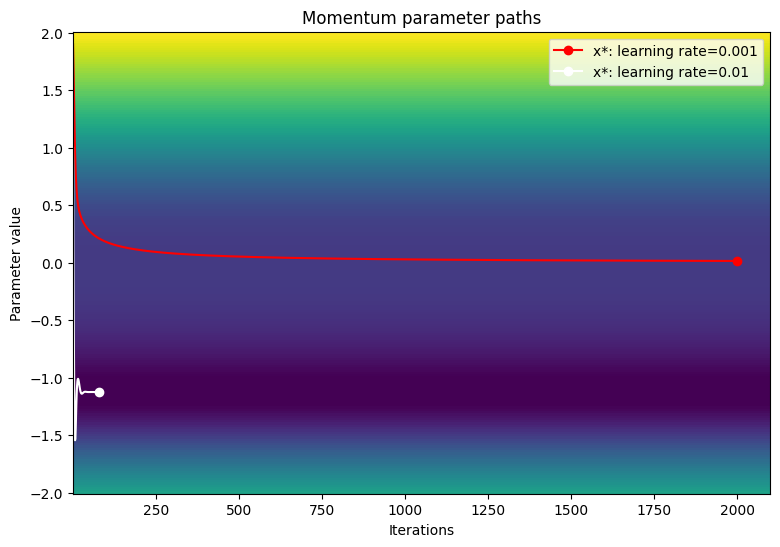

In [12]:
viz_paths(param_map_mtm, x_vals, loss, "Momentum")

## Adaptive moment estimation (Adam)

The Adaptive Moment Estimation (Adam) algorithm is an efficient and highly generalizable optimization technique that leverages two key gradient descent methedologies: momentum, and root mean square propogation (RMSP). Momentum helps accelerate gradient descent by using the first moment (sum of gradients) along with a decay parameter. RMSP is similar; however, it leverages the second moment (sum of gradients squared). 

The Adam algorithm combines both the first and second moment to provide a more generalizable update rule. The sign of a variable, $x$, can be determined by computing $\frac{x}{\sqrt{x^2}}$. The Adam optimizer uses this fact to calculate an update step which is effectively a smoothed sign. Instead of calculating $\frac{x}{\sqrt{x^2}}$, the optimizer calculates a smoothed version of $x$ (first moment) and $x^2$ (second moment) for each variable update. 


**Adam algorithm**

$\beta_1 \gets 0.9 \; \triangleright \text{literature value}$

$\beta_2 \gets 0.999 \; \triangleright \text{literature value}$

$lr \gets \text{1e-3} \; \triangleright \text{configurable learning rate}$

$\epsilon \gets \text{1e-7} \; \triangleright \text{prevents divide by 0 error}$

$V_{dv} \gets \vec {\underset{n\times1}{0}} \;\triangleright \text{stores momentum updates for each variable}$

$S_{dv} \gets \vec {\underset{n\times1}{0}} \; \triangleright \text{stores RMSP updates for each variable}$

$t \gets 1$

$\text{On iteration } t:$

$\;\;\;\; \text{For} (\frac{dL}{dv}, v) \text{ in gradient variable pairs}:$

$\;\;\;\;\;\;\;\; V_{dv\_i} = \beta_1V_{dv\_i} + (1 - \beta_1)\frac{dL}{dv} \; \triangleright \text{momentum update}$

$\;\;\;\;\;\;\;\; S_{dv\_i} = \beta_2V_{dv\_i} + (1 - \beta_2)(\frac{dL}{dv})^2 \; \triangleright \text{RMSP update}$

$\;\;\;\;\;\;\;\; v_{dv}^{bc} = \frac{V_{dv\_i}}{(1-\beta_1)^t} \; \triangleright \text{momentum bias correction}$

$\;\;\;\;\;\;\;\; s_{dv}^{bc} = \frac{S_{dv\_i}}{(1-\beta_2)^t} \; \triangleright \text{RMSP bias correction}$

$\;\;\;\;\;\;\;\; v = v - lr\frac{v_{dv}^{bc}}{\sqrt{s_{dv}^{bc}} + \epsilon} \; \triangleright \text{parameter update}$

$\;\;\;\;\;\;\;\; t = t + 1$

**End of algorithm**

Given that $V_{dv}$ and $S_{dv}$ are initialized to 0 and that $\beta_1$ and $\beta_2$ are close to 1, the momentum and RMSP updates are naturally biased towards 0; therefore, the variables can benefit from bias correction. Bias correction also helps to control the osccilation of weights as they approach the global minimum.

In [13]:
class Adam(tf.Module):
  
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize the Adam parameters
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.title = f"Adam: learning rate={self.learning_rate}"
      self.built = False

    def apply_gradients(self, grads, vars):
      # Set up moment and RMSprop slots for each variable on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Perform Adam updates
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        # Moment calculation
        self.v_dvar[i] = self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var
        # RMSprop calculation
        self.s_dvar[i] = self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var)
        # Bias correction
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        # Update model variables
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      # Increment the iteration counter
      self.t += 1.

Test the performance of the Adam optimizer with the same learning rates used with the gradient descent examples. 

In [14]:
param_map_adam = {}
learning_rates = [1e-3, 1e-2, 1e-1]
for learning_rate in learning_rates:
  param_map_adam[learning_rate] = (convergence_test(
      Adam(learning_rate=learning_rate), loss_fn=loss))

Adam: learning rate=0.001
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.01
-------------------------------


Exceeded maximum of 2000 iterations. Test terminated.

Adam: learning rate=0.1
-------------------------------


Converged in 1156 iterations



Visualize the path of the parameters over a contour plot of the loss function.

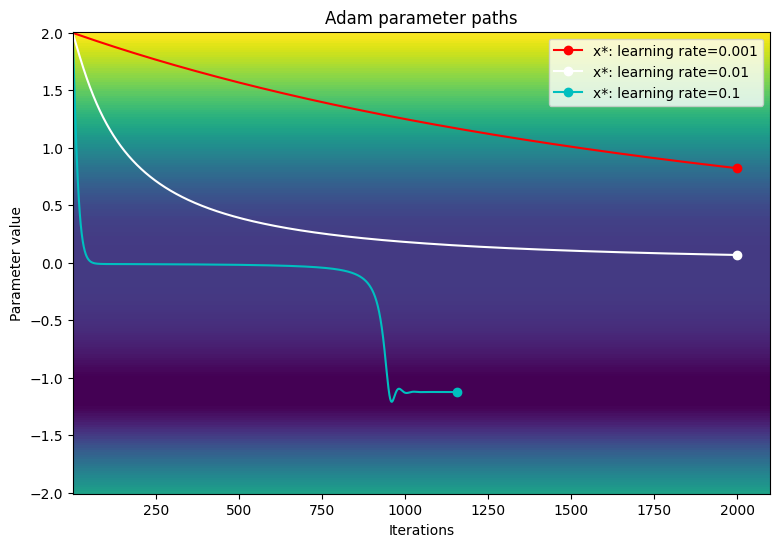

In [15]:
viz_paths(param_map_adam, x_vals, loss, "Adam")

In this particular example, the Adam optimizer has slower convergence compared to traditional gradient descent when using small learning rates. However, the algorithm successfully moves past the plataeu region and converges to the global minimum when a larger learning rate. Exploding gradients are no longer an issue due to Adam's dynamic scaling of learning rates when encountering large gradients.

## Conclusion

This notebook introduced the basics of writing and comparing optimizers with the [TensorFlow Core APIs](https://www.tensorflow.org/guide/core). Although prebuilt optimizers like Adam are generalizable, they may not always be the best choice for every model or dataset. Having fine-grained control over the optimization process can help streamline ML training workflows and improve overall performance. Refer to the following documentation for more examples of custom optimizers:

*   This Adam optimizer is used in the [Multilayer perceptrons](https://www.tensorflow.org/guide/core/mlp_core) tutorial and the [Distributed training]()
*   [Model Garden](https://blog.tensorflow.org/2020/03/introducing-model-garden-for-tensorflow-2.html) has a variety of [custom optimizers](https://github.com/tensorflow/models/tree/master/official/modeling/optimization) written with the Core APIs.
